In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, size, udf, sum, count


from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

import numpy as np
from math import floor, ceil
from itertools import zip_longest

In [11]:
def convert_to_ses(QE_info):
    if isinstance(QE_info, list):
        arr_QE = np.array(list(zip_longest(*QE_info, fillvalue=0))).T
    elif type(QE_info) == np.ndarray:
        arr_QE = QE_info
    else:
        raise ValueError("Cannot read QE information for the cut!")
    assert arr_QE.shape == (4, 3), "Wrong QE information for the cut!"
    
    if np.any(arr_QE[:, 0] > arr_QE[:, 1]):
        print("Reminder: starting > ending porints. They'll be switched. You can force quit if you want.")
        starts, ends = np.amin(arr_QE[:, :2], axis=1), np.amax(arr_QE[:, :2], axis=1)
    else:
        starts, ends = arr_QE[:, 0], arr_QE[:, 1]
    
    steps = np.abs(arr_QE[:, 2])
    if np.any(steps > ends - starts):
        raise ValueError("Invalid steps!")
        
    return starts, ends, steps

# test:
#print(convert_to_ses([[2, 1, 0.1], [1, 3], [2, 4, 0.2], [1, 5, 10]]))

In [29]:
def cut(infile, QE_info, sorted_res=True):
    spark = SparkSession.builder.master('local').appName("slice").getOrCreate()
    dataschema = StructType([ StructField("H", FloatType(), False), \
                              StructField("K", FloatType(), False), \
                              StructField("L", FloatType(), False), \
                              StructField("E", FloatType(), False), \
                              StructField("I", FloatType(), False)])
    df = spark.read.csv(infile, sep=",", schema=dataschema)
    starts, ends, steps = convert_to_ses(QE_info)
    heads = ['H', 'K', 'L', 'E']
    
    res_heads, res_shape = [], []
    
    df_in_range = df.filter((df.H>=starts[0]) & (df.H<ends[0]) & \
                            (df.K>=starts[1]) & (df.K<ends[1]) & \
                            (df.L>=starts[2]) & (df.L<ends[2]) & \
                            (df.E>=starts[3]) & (df.E<ends[3]))
    
    for col_ix, col_name in enumerate(heads):
        if steps[col_ix] != 0 and steps[col_ix] != ends[col_ix] - starts[col_ix]:
            res_heads.append(col_name+'_bin_ix')
            res_shape.append( ceil((ends[col_ix] - starts[col_ix]) / steps[col_ix]) )
            find_ix = UserDefinedFunction(lambda x: floor( (x-starts[col_ix])/steps[col_ix] ), IntegerType())
            df_in_range = df_in_range.withColumn(col_name+'_bin_ix', find_ix(col_name))
    
    if not res_heads: # means 0-Dimension
        spark.stop()
        return np.array(df.groupBy().avg('I').collect())
        
    raw_res = np.array(df_in_range.groupBy(*res_heads).agg({'I': 'mean'}).collect())
    spark.stop()
    
    if sorted_res:
        res = np.full((*res_shape), np.nan)
        if len(res_shape) == 1: # means 1-Dimension
            for row in raw_res:
                res[int(row[0])] = row[1]
        else:
            for row in raw_res:
                res[tuple(row[:-1].astype(int))] = row[-1]
        return res
    else:
        return raw_res


# test:
infile = "/Users/shenyang/Documents/NaBr/INS-code/QEI_no_nan_no_zero.csv"
QE_info = [[-3.5, -2.5, 0.02], [-3.1, -2.9], [-1.1, -0.9], [-4, 4]]
dat = cut(infile, QE_info)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[0.00110277 0.00104797 0.00108539 0.00105011 0.00104604 0.00114723
 0.00104596 0.0011417  0.00107886 0.00109402 0.00104399 0.00109425
 0.0011111  0.00117006 0.00120672 0.00119317 0.00124012 0.00127846
 0.00143057 0.00317648 0.0165189  0.02838897 0.04296856 0.03796426
 0.02829523 0.01666717 0.01074604 0.00686767 0.00416563 0.00370143
 0.00217619 0.00174712 0.00153887 0.00187881 0.00313707 0.00460929
 0.00567883 0.00574943 0.00591336 0.00488952 0.00467091 0.00441788
 0.00399546 0.00387867 0.00342063 0.00283484 0.00239551 0.00222367
 0.00177182 0.00160049]


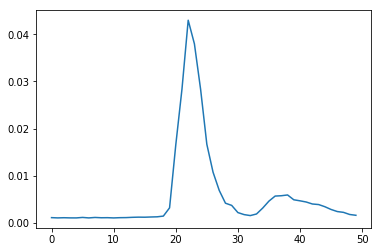

In [27]:
raw_res, res_shape = dat1, dat2
res = np.full((*res_shape), np.nan)
print(res)
if len(res_shape) == 1: # means 1-Dimension
    for row in raw_res:
        res[int(row[0])] = row[1]
print(res)
import matplotlib.pyplot as plt
#dat = dat[dat[:, 0].argsort()]
plt.plot(res)
plt.show()

In [7]:
“”“
def slice(infile, QE_info):
    spark = SparkSession.builder.master('local').appName("slice").getOrCreate()
    dataschema = StructType([ StructField("H", FloatType(), False), \
                          StructField("K", FloatType(), False), \
                          StructField("L", FloatType(), False), \
                          StructField("E", FloatType(), False), \
                          StructField("I", FloatType(), False)])
    df = spark.read.csv(infile, sep=",", schema=dataschema)
    starts, ends, steps = convert_to_ses(QE_info)
    heads = ['H', 'K', 'L', 'E']
    ix_no_step = []
    ix_exist_step = []
    df_in_range = df.filter((df.H>=starts[0]) & (df.H<ends[0]) &\
                            (df.K>=starts[1]) & (df.K<ends[1]) &\
                            (df.L>=starts[2]) & (df.L<ends[2]) &\
                            (df.E>=starts[3]) & (df.E<ends[3]))
    
    for col_ix, col_name in enumerate(heads):
        if steps[col_ix] == 0 or steps[col_ix] == ends[col_ix] - starts[col_ix]:
            ix_no_step.append(col_ix)
        else:
            ix_exist_step.append(col_name+'_bin_ix')
            find_ix = UserDefinedFunction(lambda x: floor( (x-starts[col_ix])/steps[col_ix] ), IntegerType())
            df_in_range = df_in_range.withColumn(col_name+'_bin_ix', find_ix(col_name))
            
    res = np.array(df_in_range.groupBy(*ix_exist_step).agg({'I': 'mean'}).collect())
    
    spark.stop()
    
    return res
“”“
# test:
#infile = "/Users/shenyang/Documents/NaBr/INS-code/QEI_no_nan_no_zero.csv"
#QE_info = [[-3.5, -2.5, 0.02], [-3.1, -2.9], [-1.1, -0.9], [-4, 4]]
#dat = slice(infile, QE_info)
    

AttributeError: 'NoneType' object has no attribute '_jvm'

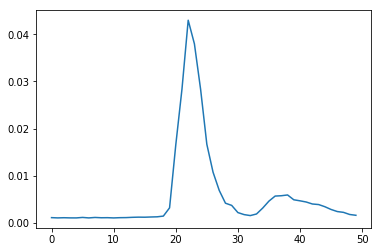

In [30]:
import matplotlib.pyplot as plt
#dat = dat[dat[:, 0].argsort()]
plt.plot(dat)
plt.show()